# Hypothesis Testing in Python
Run the hidden code cell below to import the data used in this course.

In [1]:
# Import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm,chisquare
import pingouin
from statsmodels.stats.proportion import proportions_ztest

# Import the course datasets (the're al samples)
republican_votes = pd.read_feather('datasets/repub_votes_potus_08_12.feather')
democrat_votes = pd.read_feather('datasets/dem_votes_potus_12_16.feather')
shipments = pd.read_feather('datasets/late_shipments.feather')
stackoverflow = pd.read_feather("datasets/stack_overflow.feather")

# 1. Introduction to Hypothesis Testing

How does hypothesis testing work and what problems can it solve? To find out, you’ll walk through the workflow for a one sample proportion test. In doing so, you'll encounter important concepts like z-scores, p-values, and false negative and false positive errors.

## Hypothesis tests and z-scores

### Calculating the sample mean
The shipments dataset contains supply chain data on the delivery of medical supplies. Each row represents one delivery of a part. The late columns denotes whether or not the part was delivered late. A value of "Yes" means that the part was delivered late, and a value of "No" means the part was delivered on time.

You'll begin your analysis by calculating a point estimate (or sample statistic), namely the proportion of late shipments.

In pandas, a value's proportion in a categorical DataFrame column can be quickly calculated using the syntax:

prop = (df['col'] == val).mean()
shipments is available, and pandas is loaded as pd.

In [2]:
shipments.shape

(1000, 27)

In [3]:
# Calculate the proportion of late shipments
late_prop_samp = (shipments['late']=='Yes').mean()

# Print the results
print(late_prop_samp)

0.061


### Make a Bootstrap Sample of the late shipments

Use 5000 samples

In [4]:
late_shipments_boot_distn = []

for i in range(5000):
    late_shipments_boot_distn.append(\
         np.mean(shipments.sample(frac=1,replace=True)['late'] == 'Yes')\
                                    )

In [5]:
late_prop_samp = np.mean(late_shipments_boot_distn)
print(late_prop_samp)

0.0611482


### Calculating a z-score
Since variables have arbitrary ranges and units, we need to standardize them. For example, a hypothesis test that gave different answers if the variables were in Euros instead of US dollars would be of little value. Standardization avoids that.

One standardized value of interest in a hypothesis test is called a z-score. To calculate it, you need three numbers: the sample statistic (point estimate), the hypothesized statistic, and the standard error of the statistic (estimated from the bootstrap distribution).

The sample statistic is available as late_prop_samp.

late_shipments_boot_distn is a bootstrap distribution of the proportion of late shipments, available as a list.

pandas and numpy are loaded with their usual aliases.

In [6]:
# Hypothesize that the proportion is 6%
late_prop_hyp = 0.06

# Calculate the standard error
std_error = np.std(late_shipments_boot_distn,ddof=1)

# Find z-score of late_prop_samp
z_score = (late_prop_samp - late_prop_hyp)/std_error

# Print z_score
print(z_score)

0.15055247846000827


## p-values

### Calculating p-values
In order to determine whether to choose the null hypothesis or the alternative hypothesis, you need to calculate a p-value from the z-score.

You'll now return to the late shipments dataset and the proportion of late shipments.

The null hypothesis, _Ho_, is that the proportion of late shipments is six percent.

The alternative hypothesis, _Ha_, is that the proportion of late shipments is **greater than**  six percent.

The observed sample statistic, late_prop_samp, the hypothesized value, late_prop_hyp (6%), and the bootstrap standard error, std_error are available. norm from scipy.stats has also been loaded without an alias.

In [7]:
# Calculate the z-score of late_prop_samp
z_score = (late_prop_samp - late_prop_hyp)/std_error

# Calculate the p-value
p_value = 1 - norm.cdf(z_score,loc=0,scale=1)
                 
# Print the p-value
print(p_value) 

0.4401643753379413


## Statistical significance

### Calculating a confidence interval
If you give a single estimate of a sample statistic, you are bound to be wrong by some amount. For example, the hypothesized proportion of late shipments was 6%. Even if evidence suggests the null hypothesis that the proportion of late shipments is equal to this, for any new sample of shipments, the proportion is likely to be a little different due to sampling variability. Consequently, it's a good idea to state a confidence interval. That is, you say, "we are 95% 'confident' that the proportion of late shipments is between A and B" (for some value of A and B).

Sampling in Python demonstrated two methods for calculating confidence intervals. Here, you'll use quantiles of the bootstrap distribution to calculate the confidence interval.

late_prop_samp and late_shipments_boot_distn are available; pandas and numpy are loaded with their usual aliases.

***CAUTION!!!***

- A p-test means: _If the null Hypothesis is TRUE, then what is the probability of a certain statistic is the value that we've obtained ?_
- If p is high it means that the obtained value is very likely. 
- High and low are determined by the confindence interval (CI). High means greater than the CI and Low means smaller than the CI.

### Calculating a confidence interval
If you give a single estimate of a sample statistic, you are bound to be wrong by some amount. For example, the hypothesized proportion of late shipments was 6%. Even if evidence suggests the null hypothesis that the proportion of late shipments is equal to this, for any new sample of shipments, the proportion is likely to be a little different due to sampling variability. Consequently, it's a good idea to state a confidence interval. That is, you say, "we are 95% 'confident' that the proportion of late shipments is between A and B" (for some value of A and B).

Sampling in Python demonstrated two methods for calculating confidence intervals. Here, you'll use quantiles of the bootstrap distribution to calculate the confidence interval.

late_prop_samp and late_shipments_boot_distn are available; pandas and numpy are loaded with their usual aliases.

In [8]:
# Calculate 95% confidence interval using quantile method
lower = np.quantile(late_shipments_boot_distn,0.025)
upper = np.quantile(late_shipments_boot_distn,0.975)

# Print the confidence interval
print((lower, upper))

(0.046, 0.077)


**Question:**
 Does the confidence interval match up with the conclusion to stick with the original assumption that **6%** is a reasonable value for the unknown population parameter?

**Yes**, since 0.06 is included in the 95% confidence interval and we failed to reject 
 due to a large p-value, the results are similar.

## Type I and type II errors
For hypothesis tests and for criminal trials, there are two states of truth and two possible outcomes. Two combinations are correct test outcomes, and there are two ways it can go wrong.

The errors are known as false positives (or "type I errors"), and false negatives (or "type II errors").

![image-2](image-2.png)


# 2. Two-Sample and ANOVA Tests
In this chapter, you’ll learn how to test for differences in means between two groups using t-tests and extend this to more than two groups using ANOVA and pairwise t-tests.

## Performing t-tests

### Hypothesis testing workflow
You've seen the hypothesis testing workflow for the one sample case where you compared a sample mean to a hypothesized value, and the two sample case where you compared two sample means. In both cases, the workflow shares common steps.

![image-3](image-3.png)


### Two sample mean test statistic
The hypothesis test for determining if there is a difference between the means of two populations uses a different type of test statistic to the z-scores you saw in Chapter 1. It's called "t", and it can be calculated from three values from each sample using this equation.

 
 
![image-4](image-4.png)
 

While trying to determine why some shipments are late, you may wonder if the weight of the shipments that were on time is less than the weight of the shipments that were late. 

In [9]:
# Get the Sample Sizes n_yes and n_no for Yes and No groups
n_yes = len(shipments.query('late=="Yes"')['weight_kilograms'])
n_no = len(shipments.query('late=="No"')['weight_kilograms'])

#Get the means for Yes and No cases as xbar_yes and xbar_no
xbar_yes = np.mean(shipments.query('late=="Yes"')['weight_kilograms'])
xbar_no = np.mean(shipments.query('late=="No"')['weight_kilograms'])

#Get the SD for Yes and No cases as s_yes and s_no
s_yes = np.std(shipments.query('late=="Yes"')['weight_kilograms'],ddof=1)
s_no = np.std(shipments.query('late=="No"')['weight_kilograms'],ddof=1)

In [10]:
print(n_yes,n_no,xbar_yes,xbar_no,s_yes,s_no,sep='\n')

61
939
2715.6721311475408
1897.7912673056444
2544.688210903328
3154.0395070841696


The shipments dataset has been split into a "yes" group, where late == "Yes" and a "no" group where late == "No". The weight of the shipment is given in the weight_kilograms variable.

The sample means for the two groups are available as xbar_no and xbar_yes. The sample standard deviations are s_no and s_yes. The sample sizes are n_no and n_yes. numpy is also loaded as np.

In [11]:
# Calculate the numerator of the test statistic
numerator = xbar_yes-xbar_no

# Calculate the denominator of the test statistic
denominator = np.sqrt((s_yes**2)/n_yes + (s_no**2)/n_no)

# Calculate the test statistic
t_stat = numerator/denominator

# Print the test statistic
print(t_stat)

2.3936661778766433


## Paired t-tests

### Visualizing the difference

Before you start running hypothesis tests, it's a great idea to perform some exploratory data analysis; that is, calculating summary statistics and visualizing distributions.

Here, you'll look at the proportion of county-level votes for the Democratic candidate in 2012 and 2016, sample_dem_data. Since the counties are the same in both years, these samples are paired. The columns containing the samples are dem_percent_12 and dem_percent_16.

dem_votes_potus_12_16 is available as sample_dem_data. pandas and matplotlib.pyplot are loaded with their usual aliases.

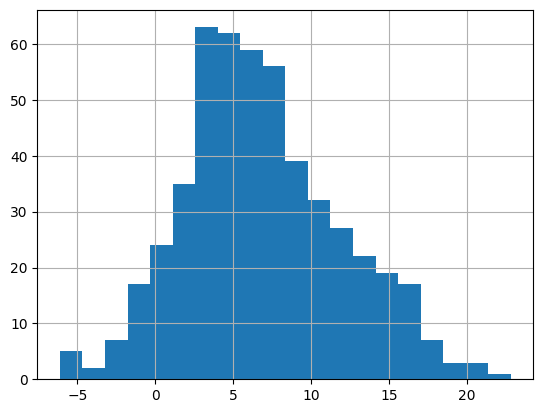

In [12]:
sample_dem_data = democrat_votes

# Calculate the differences from 2012 to 2016
sample_dem_data['diff'] = sample_dem_data['dem_percent_12'] - sample_dem_data['dem_percent_16']

# Find the mean of the diff column
xbar_diff = sample_dem_data['diff'].mean()

# Find the standard deviation of the diff column
s_diff = sample_dem_data['diff'].std()

# Plot a histogram of diff with 20 bins
sample_dem_data['diff'].hist(bins=20)
plt.show()

## ANOVA TESTS

### Visualizing many categories

So far in this chapter, we've only considered the case of differences in a numeric variable between two categories. Of course, many datasets contain more categories. Before you get to conducting tests on many categories, it's often helpful to perform exploratory data analysis (EDA), calculating summary statistics for each group and visualizing the distributions of the numeric variable for each category using box plots.

Here, we'll return to the late shipments data, and how the price of each package (pack_price) varies between the three shipment modes (shipment_mode): "Air", "Air Charter", and "Ocean".

_shipments_ is available; pandas and matplotlib.pyplot are loaded with their standard aliases, and seaborn is loaded as sns.


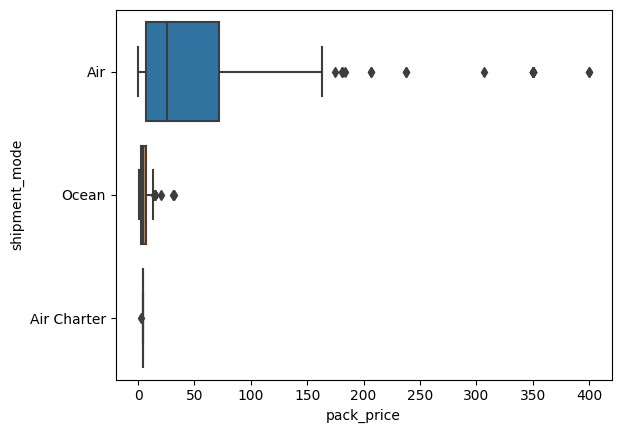

In [13]:
# Calculate the mean pack_price for each shipment_mode
xbar_pack_by_mode = shipments.groupby("shipment_mode")['pack_price'].mean()

# Calculate the standard deviation of the pack_price for each shipment_mode
s_pack_by_mode = shipments.groupby("shipment_mode")['pack_price'].std()

# Boxplot of shipment_mode vs. pack_price
sns.boxplot(x="pack_price",y="shipment_mode",data=shipments)

plt.show()

### Conducting an ANOVA test

The box plots made it look like the distribution of pack price was different for each of the three shipment modes. However, it didn't tell us whether the mean pack price was different in each category. To determine that, we can use an ANOVA test. The null and alternative hypotheses can be written as follows.

_Ho_: Pack prices for every category of shipment mode are the same.

_Ha_: Pack prices for some categories of shipment mode are different.

Use a significance level of 0.1.

_shipments_ is available and pingouin has been loaded.

In [14]:
# Run an ANOVA for pack_price across shipment_mode
anova_results = pingouin.anova(data=shipments,dv='pack_price',between='shipment_mode')

# Print anova_results
print(anova_results)

          Source  ddof1  ddof2        F         p-unc       np2
0  shipment_mode      2    997  21.8646  5.089479e-10  0.042018


### Pairwise t-tests

The ANOVA test didn't tell you which categories of shipment mode had significant differences in pack prices. To pinpoint which categories had differences, you could instead use pairwise t-tests.

shipments is available and pingouin has been loaded.

In [15]:
# Perform a pairwise t-test on pack price, grouped by shipment mode
pairwise_results =  pingouin.pairwise_tests(data=shipments,dv='pack_price',between = 'shipment_mode', padjust='none')

# Print pairwise_results
print(pairwise_results)

        Contrast            A            B  ...         p-unc       BF10    hedges
0  shipment_mode          Air  Air Charter  ...  8.748346e-75  5.809e+76  0.726592
1  shipment_mode          Air        Ocean  ...  6.934555e-71  1.129e+67  0.711119
2  shipment_mode  Air Charter        Ocean  ...  3.123012e-03     15.277 -0.423775

[3 rows x 11 columns]


In [16]:
# Modify the pairwise t-tests to use Bonferroni p-value adjustment
pairwise_results = pingouin.pairwise_tests(data=shipments, 
                                           dv="pack_price",
                                           between="shipment_mode",
                                           padjust="bonf")

# Print pairwise_results
print(pairwise_results)

        Contrast            A            B  ...  p-adjust       BF10    hedges
0  shipment_mode          Air  Air Charter  ...      bonf  5.809e+76  0.726592
1  shipment_mode          Air        Ocean  ...      bonf  1.129e+67  0.711119
2  shipment_mode  Air Charter        Ocean  ...      bonf     15.277 -0.423775

[3 rows x 13 columns]


# 3. One-sample proportion tests

## Test for single proportions

In Chapter 1, you calculated a p-value for a test hypothesizing that the proportion of late shipments was greater than 6%. In that chapter, you used a bootstrap distribution to estimate the standard error of the statistic. An alternative is to use an equation for the standard error based on the sample proportion, hypothesized proportion, and sample size.

z = (p_hat - p_0)/np.sqrt(p_0*(1-p_0)/n)

You'll revisit the p-value using this simpler calculation.

shipments is available. pandas and numpy are available under their usual aliases, and norm is loaded from scipy.stats.

In [17]:
# Hypothesize that the proportion of late shipments is 6%
p_0 = 0.06

# Calculate the sample proportion of late shipments
p_hat = (shipments['late'] == "Yes").mean()

# Calculate the sample size
n = len(shipments)

# Calculate the numerator and denominator of the test statistic
numerator = p_hat - p_0
denominator = np.sqrt(p_0 * (1 - p_0) / n)

# Calculate the test statistic
z_score = numerator / denominator

# Calculate the p-value from the z-score
p_value = 1 - norm.cdf(z_score)

# Print the p-value
print(z_score,p_value)

0.13315591032282698 0.44703503936503364


## Test of two proportions
You may wonder if the amount paid for freight affects whether or not the shipment was late. Recall that in the _shipments_ dataset, whether or not the shipment was late is stored in the late column. Freight costs are stored in the _freight_cost_groups_ column, and the categories are "expensive" and "reasonable".

The hypotheses to test, with "late" corresponding to the proportion of late shipments for that group, are

![image-5](image-5.png)

_p_hats_ contains the estimates of population proportions (sample proportions) for each freight_cost_group:

![image-6](image-6.png)

_ns_ contains the sample sizes for these groups:

![image-7](image-7.png)

_pandas_ and _numpy_ have been imported under their usual aliases, and _norm_ is available from _scipy.stats_.


In [18]:
#Obtain p_hats and ns

p_hats = shipments[["freight_cost_groups","late"]]\
        .groupby("freight_cost_groups").value_counts(normalize=True)\
        .drop([( 'expensive', 'No'),('reasonable', 'No')]) 

ns = shipments["freight_cost_groups"].value_counts()

print(n,p_hats,ns,sep=2*'\n')


1000

freight_cost_groups  late
expensive            Yes     0.079096
reasonable           Yes     0.035165
dtype: float64

expensive     531
reasonable    455
Name: freight_cost_groups, dtype: int64


In [19]:
# Calculate the pooled estimate of the population proportion
p_hat = (ns['expensive']*p_hats['expensive']+ \
            ns['reasonable']*p_hats['reasonable']) \
            /(ns['expensive']+ns['reasonable'])

# Calculate p_hat one minus p_hat
p_hat_times_not_p_hat = p_hat*(1-p_hat)

# Divide this by each of the sample sizes and then sum
p_hat_times_not_p_hat_over_ns = p_hat_times_not_p_hat/ns['expensive'] + p_hat_times_not_p_hat/ns['reasonable']

# Calculate the standard error
std_error = np.sqrt(p_hat_times_not_p_hat_over_ns)

# Calculate the z-score
z_score = (p_hats['expensive']- p_hats['reasonable'])/std_error

# Calculate the p-value from the z-score
p_value = 1-norm.cdf(z_score)

# Print p_value
print(z_score,'%.12f' % p_value)

late
Yes    2.922649
dtype: float64 0.001735340002


### proportions_ztest() for two samples
That took a lot of effort to calculate the p-value, so while it is useful to see how the calculations work, it isn't practical to do in real-world analyses. For daily usage, it's better to use the statsmodels package.

Recall the hypotheses.

![image-5](image-5.png)

shipments is available, containing the freight_cost_group column. numpy and pandas have been loaded under their standard aliases, and proportions_ztest has been loaded from statsmodels.stats.proportion.

In [20]:
# Count the late column values for each freight_cost_group
late_by_freight_cost_group = shipments.groupby("freight_cost_groups")['late'].value_counts()

# Create an array of the "Yes" counts for each freight_cost_group
success_counts = np.array([late_by_freight_cost_group["expensive","Yes"], late_by_freight_cost_group["reasonable","Yes"]])

# Create an array of the total number of rows in each freight_cost_group
n = shipments.groupby("freight_cost_groups")['late'].count()

# Run a z-test on the two proportions
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative="larger")

# Print the results
print(stat, p_value)

2.922648567784529 0.001735340002359578


### Performing a chi-square test
The chi-square independence test compares proportions of successes of one categorical variable across the categories of another categorical variable.

Trade deals often use a form of business shorthand in order to specify the exact details of their contract. These are International Chamber of Commerce (ICC) international commercial terms, or incoterms for short.

The _shipments_ dataset includes a vendor_inco_term that describes the incoterms that applied to a given shipment. The choices are:

EXW: "Ex works". The buyer pays for transportation of the goods.
CIP: "Carriage and insurance paid to". The seller pays for freight and insurance until the goods board a ship.
DDP: "Delivered duty paid". The seller pays for transportation of the goods until they reach a destination port.
FCA: "Free carrier". The seller pays for transportation of the goods.
Perhaps the incoterms affect whether or not the freight costs are expensive. Test these hypotheses with a significance level of 0.01.

_Ho_: vendor_inco_term and freight_cost_group are independent.

_Ha_: vendor_inco_term and freight_cost_group are associated.

_shipments_ is available, and the following have been loaded: matplotlib.pyplot as plt, pandas as pd, and pingouin.

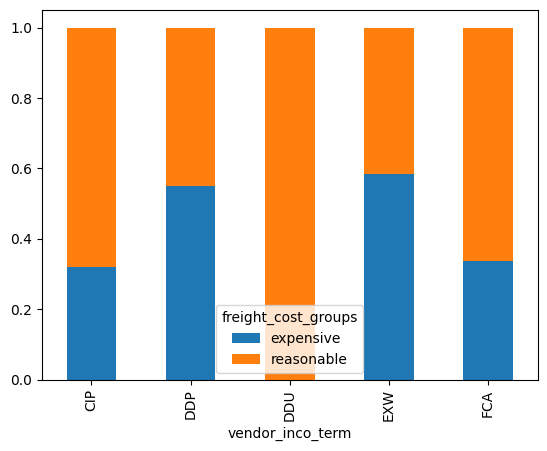

34.80507227612312


In [21]:
# Proportion of freight_cost_group grouped by vendor_inco_term
props = shipments.groupby('vendor_inco_term')['freight_cost_groups'].value_counts(normalize=True)

# Convert props to wide format
wide_props = props.unstack()

# Proportional stacked bar plot of freight_cost_group vs. vendor_inco_term
wide_props.plot(kind="bar", stacked=True)
plt.show()

# Determine if freight_cost_group and vendor_inco_term are independent
expected, observed, stats = pingouin.chi2_independence(data=shipments,\
                                 x="freight_cost_groups",y="vendor_inco_term")

direct_pearson_chi2 = stats[stats['test'] == 'pearson'].iloc[0].loc['chi2']

# Print results
print(direct_pearson_chi2) 

**Seems necessary to drop lines where vendor_inco_term is DDU**

In [22]:
shipments = shipments.drop(shipments[shipments['vendor_inco_term'] == 'DDU'].index)

### Swapping variables

If the values are the same, then the test failed to reject the null hypothesis.

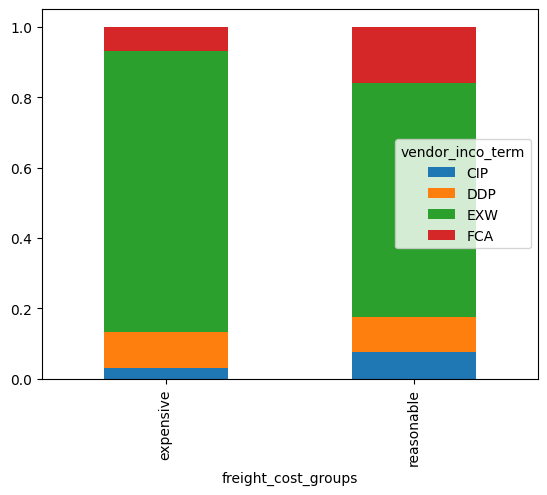

33.64259996923901


In [23]:
# Proportion of freight_cost_group grouped by vendor_inco_term
props = shipments.groupby('freight_cost_groups')['vendor_inco_term'].value_counts(normalize=True)

# Convert props to wide format
wide_props = props.unstack()

# Proportional stacked bar plot of freight_cost_group vs. vendor_inco_term
wide_props.plot(kind="bar", stacked=True)
plt.show()

# Determine if freight_cost_group and vendor_inco_term are independent
expected, observed, stats = pingouin.chi2_independence(data=shipments,\
                                 x="vendor_inco_term",y="freight_cost_groups")

swap_pearson_chi2 = stats[stats['test'] == 'pearson'].iloc[0].loc['chi2'] 
# Print results
print(swap_pearson_chi2) 

## Chi-square goodness of fit tests

### Visualizing goodness of fit
The chi-square goodness of fit test compares proportions of each level of a categorical variable to hypothesized values. Before running such a test, it can be helpful to visually compare the distribution in the sample to the hypothesized distribution.

Recall the vendor incoterms in the shipments dataset. You hypothesize that the four values occur with these frequencies in the population of shipments.

- CIP: 0.05
- DDP: 0.1
- EXW: 0.75
- FCA: 0.1

These frequencies are stored in the hypothesized DataFrame.

The incoterm_counts DataFrame stores the .value_counts() of the vendor_inco_term column.

In [24]:
incoterm_counts = pd.DataFrame(shipments['vendor_inco_term'].value_counts())
vendor_inco_term = pd.Series(incoterm_counts.index)
n=incoterm_counts[incoterm_counts.columns[0]]
incoterm_counts["n"] = n
incoterm_counts = incoterm_counts.reset_index(drop=True)
incoterm_counts = incoterm_counts.drop(columns="vendor_inco_term")
incoterm_counts["vendor_inco_term"] = vendor_inco_term
incoterm_counts = incoterm_counts[["vendor_inco_term","n"]]
print(incoterm_counts)    


  vendor_inco_term    n
0              EXW  732
1              FCA  111
2              DDP  100
3              CIP   56


In [25]:
hypothesized = pd.DataFrame({incoterm_counts.columns[0]:incoterm_counts.iloc[:,0],
                            "prop":[0.75,0.10,0.10,0.05]}
                           )
hypothesized

,vendor_inco_term,prop
0,EXW,0.75
1,FCA,0.10
2,DDP,0.10
3,CIP,0.05


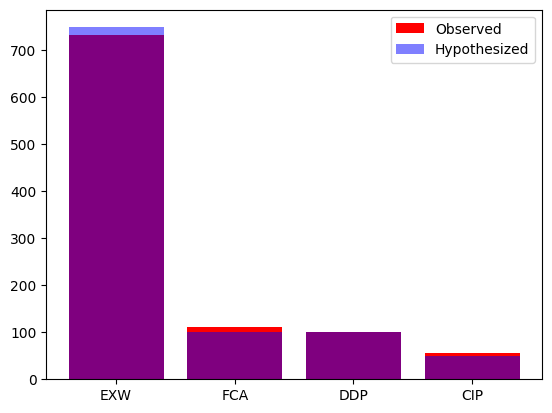

In [26]:
# Find the number of rows in shipments
n_total = len(shipments)

# Create n column that is prop column * n_total
hypothesized["n"] = hypothesized["prop"] * n_total

# Plot a red bar graph of n vs. vendor_inco_term for incoterm_counts
plt.bar(incoterm_counts['vendor_inco_term'], incoterm_counts['n'], color="red", label="Observed")

# Add a blue bar plot for the hypothesized counts
plt.bar(hypothesized['vendor_inco_term'], hypothesized['n'], color="blue", label="Hypothesized",alpha=0.5)
plt.legend()
plt.show()

### Performing a goodness of fit test

The bar plot of vendor_inco_term suggests that the distribution across the four categories was quite close to the hypothesized distribution. You'll need to perform a chi-square goodness of fit test to see whether the differences are statistically significant.

Recall the hypotheses for this type of test:

_Ho_: The sample matches with the hypothesized distribution.

_Ha_: The sample does not match with the hypothesized distribution.

To decide which hypothesis to choose, we'll set a significance level of 0.1.

shipments, incoterm_counts, and hypothesized from the last exercise are available. chisquare from scipy.stats has been loaded.

In [27]:
# Perform a goodness of fit test on the incoterm counts n
gof_test = chisquare(f_obs=incoterm_counts['n'], f_exp=hypothesized['n'])


# Print gof_test results
print(gof_test)

Power_divergenceResult(statistic=2.3633633633633613, pvalue=0.5004909543758689)


As p_value > alpha, the test Fail to reject the null hypothesis. So It is possible that _The sample matches with the hypothesized distribution_ .

# 4. Non-Parametric Tests


## Assumptions in hypothesis testing

### Testing sample size
In order to conduct a hypothesis test and be sure that the result is fair, a sample must meet three requirements: it is a random sample of the population, the observations are independent, and there are enough observations. Of these, only the last condition is easily testable with code.

The minimum sample size depends on the type of hypothesis tests you want to perform. You'll now test some scenarios on the shipments dataset.

Note that the .all() method from pandas can be used to check if all elements are true. For example, given a DataFrame df with numeric entries, you check to see if all its elements are less than 5, using (df < 5).all().

shipments is available, and pandas is loaded as pd.

- Get the count of each value in the freight_cost_group column of shipments.
- Insert a suitable number to inspect whether the counts are "big enough" for a two sample t-test.

In [32]:
# Count the freight_cost_group values
counts = shipments['freight_cost_groups'].value_counts()

# Print the result
print(counts)

# Inspect whether the counts are big enough
print((counts >= 30).all())

expensive     531
reasonable    454
Name: freight_cost_groups, dtype: int64
True


- Get the count of each value in the _late_ column of _shipments_.
- Insert a suitable number to inspect whether the counts are "big enough" for a one sample proportion test.

In [33]:
# Count the late values
counts = shipments["late"].value_counts()

# Print the result
print(counts)

# Inspect whether the counts are big enough
print((counts >= 10).all())

No     938
Yes     61
Name: late, dtype: int64
True


- Get the count of each value in the freight_cost_group column of late_shipments grouped by vendor_inco_term.
- Insert a suitable number to inspect whether the counts are "big enough" for a chi-square independence test.

In [35]:
# Count the values of freight_cost_group grouped by vendor_inco_term
counts = shipments.groupby("vendor_inco_term")['freight_cost_groups'].value_counts()

# Print the result
print(counts)

# Inspect whether the counts are big enough
print((counts >= 5).all())

vendor_inco_term  freight_cost_groups
CIP               reasonable              34
                  expensive               16
DDP               expensive               55
                  reasonable              45
EXW               expensive              423
                  reasonable             302
FCA               reasonable              73
                  expensive               37
Name: freight_cost_groups, dtype: int64
True


- Get the count of each value in the shipment_mode column of late_shipments.
- Insert a suitable number to inspect whether the counts are "big enough" for an ANOVA test.

In [37]:
# Count the shipment_mode values
counts = shipments['shipment_mode'].value_counts()

# Print the result
print(counts)

# Inspect whether the counts are big enough
print((counts >= 30).all())

Air            905
Ocean           88
Air Charter      6
Name: shipment_mode, dtype: int64
False
